In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torchinfo
from torch.utils.data import DataLoader, Dataset
from torchlake.common.controller.evaluator import RegressionEvaluator
from torchlake.common.controller.trainer import RegressionTrainer
from torchlake.common.utils.platform import get_file_size, get_num_workers
from torchlake.sequence_data.models.lstnet import LSTNet

In [2]:
torch.__version__

'2.1.0+cu118'

# setting


In [3]:
from matplotlib import rcParams
import matplotlib.font_manager as fm

# prop = fm.FontProperties(fname="E://NotoSansTC-Light.otf")
fm.fontManager.addfont("E://NotoSansTC-Light.otf")

rcParams['font.family'] = 'Noto Sans TC'

In [4]:
BATCH_SIZE = 128

In [5]:
artifact_path = Path("../../artifacts/lstnet")
artifact_path.mkdir(exist_ok=True)

data_path = Path("../../data/taipei-mrt")

In [6]:
DEVICE = torch.device("cuda:0")

In [7]:
LONG_WINDOW_SIZE = 30 # month
SHORT_WINDOW_SIZE = 7 # week

# dataset


In [8]:
# %pip install odfpy

In [9]:
# from itertools import product
# import os
# import requests

# url_template = "https://web.metro.taipei/RidershipPerStation/{year}{month}_cht.ods"
# for year, month in product([2022, 2023, 2024], range(1, 13, 1)):
#     month = str(month).zfill(2)
#     url = url_template.format(year=year, month=month)
    
#     response = requests.get(url, stream=True)
#     filename = os.path.basename(url)
#     data_path.joinpath(filename).write_bytes(response.content)

In [10]:
import pandas as pd
import numpy as np
from itertools import chain

class TaipeiMRT(Dataset):
    def __init__(
        self, 
        root: str | Path, 
        years: list[int], 
        window_size: int,
        transform = None,
        target_transform = None,
    ):
        data = pd.concat(
            [
                pd.read_excel(
                    p,
                    sheet_name="進站資料",
                    parse_dates=["　　　　車站日期"],
                    index_col="　　　　車站日期",
                )
                for p in chain(*[root.glob(f"{year}*.ods") for year in years])
            ]
        )

        self.root = Path(root)
        self.stations = data.columns.to_list()
        self.data = data.to_numpy()
        self.window_size = window_size
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        frontier = idx+self.window_size
        x, y = self.data[idx:frontier], self.data[frontier]
        
        if self.transform:
            x = self.transform(x)
            
        if self.target_transform:
            y = self.target_transform(y)
            
        return x, y

In [11]:
def transform(x):
    x = x.astype(np.float32)
    x = x / 10_000 # scale less fluctuate
    return x

def target_transform(x):
    x = x / 10_000 # scale less fluctuate
    return x

In [12]:
train_dataset = TaipeiMRT(
    data_path,
    years=["2022", "2023"],
    window_size=LONG_WINDOW_SIZE,
    transform=transform,
    target_transform=target_transform,
)
val_dataset = TaipeiMRT(
    data_path,
    years=["2024"],
    window_size=LONG_WINDOW_SIZE,
    transform=transform,
    target_transform=target_transform,
)

In [13]:
train_dataset.data.shape, val_dataset.data.shape

((730, 119), (366, 119))

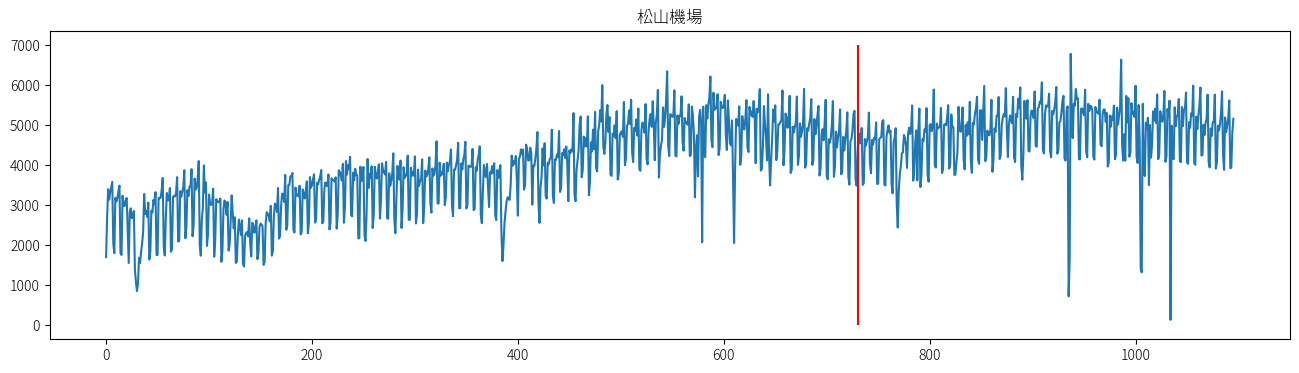

In [14]:
plt.figure(figsize=(16, 4))
plt.plot(
    np.concatenate([train_dataset.data[:, 0], val_dataset.data[:, 0]]),
)
plt.title(train_dataset.stations[0])
plt.vlines(len(train_dataset.data), 0, 7000, colors="red")

In [15]:
for past, future in train_dataset:
    print(past.shape, future.shape)
    break

(30, 119) (119,)


In [16]:
OUTPUT_SIZE = len(train_dataset.stations)
OUTPUT_SIZE

119

In [17]:
NUM_WORKERS = get_num_workers()

In [18]:
train_dataloader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
    shuffle=True,
)

val_dataloader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    num_workers=NUM_WORKERS,
)

In [19]:
for x, y in train_dataloader:
    print(x.shape, y.shape)
    break

torch.Size([128, 30, 119]) torch.Size([128, 119])


# model


In [120]:
model = LSTNet(
    hidden_dim_c=128,
    hidden_dim_r=128,
    output_size=OUTPUT_SIZE,
    kernel=SHORT_WINDOW_SIZE-1,
    window_size=LONG_WINDOW_SIZE,
    highway_window_size=SHORT_WINDOW_SIZE,
    skip_window_size=SHORT_WINDOW_SIZE,
).to(DEVICE)

In [121]:
torchinfo.summary(model)

Layer (type:depth-idx)                   Param #
LSTNet                                   --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       91,520
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
├─ModuleDict: 1-2                        --
│    └─GRU: 2-4                          99,072
│    └─Dropout: 2-5                      --
├─SkipRNN: 1-3                           --
│    └─GRU: 2-6                          2,025
│    └─Dropout: 2-7                      --
├─ModuleDict: 1-4                        --
│    └─Linear: 2-8                       19,516
│    └─Highway: 2-9                      --
│    │    └─Linear: 3-1                  8
Total params: 212,141
Trainable params: 212,141
Non-trainable params: 0

In [122]:
from torchlake.sequence_data.models.gru.model import GRUDiscriminator

baseline = GRUDiscriminator(
    input_channel=OUTPUT_SIZE,
    embed_dim=OUTPUT_SIZE,
    output_size=OUTPUT_SIZE,
    enable_embed=False,
    bidirectional=True,
).to(DEVICE)

baseline.context.padding_idx = None

In [123]:
torchinfo.summary(baseline)

Layer (type:depth-idx)                   Param #
GRUDiscriminator                         --
├─Identity: 1-1                          --
├─GRU: 1-2                               191,232
├─LayerNorm: 1-3                         512
├─Linear: 1-4                            30,583
Total params: 222,327
Trainable params: 222,327
Non-trainable params: 0

# train

## model

In [124]:
EPOCHS = 30

In [125]:
trainer = RegressionTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [126]:
criterion = trainer.get_criterion(type='l1')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)#, weight_decay=1e-3)

In [127]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [128]:
training_loss = trainer.run(train_dataloader, model, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 6/6 [00:00<00:00, 15.77it/s]


------------------------------------
Epoch 1
------------------------------------
0.01673828525202615 (0%)


100%|██████████| 6/6 [00:00<00:00, 35.09it/s]


------------------------------------
Epoch 2
------------------------------------
0.011086450644901819 (-34%)


100%|██████████| 6/6 [00:00<00:00, 48.39it/s]


------------------------------------
Epoch 3
------------------------------------
0.00808415949344635 (-27%)


100%|██████████| 6/6 [00:00<00:00, 51.28it/s]


------------------------------------
Epoch 4
------------------------------------
0.006644593988146101 (-18%)


100%|██████████| 6/6 [00:00<00:00, 57.14it/s]


------------------------------------
Epoch 5
------------------------------------
0.005551203233855112 (-16%)


100%|██████████| 6/6 [00:00<00:00, 53.10it/s]


------------------------------------
Epoch 6
------------------------------------
0.004650016597339086 (-16%)


100%|██████████| 6/6 [00:00<00:00, 56.07it/s]


------------------------------------
Epoch 7
------------------------------------
0.0036577998740332466 (-21%)


100%|██████████| 6/6 [00:00<00:00, 65.19it/s]


------------------------------------
Epoch 8
------------------------------------
0.0030861436894961767 (-16%)


100%|██████████| 6/6 [00:00<00:00, 57.69it/s]


------------------------------------
Epoch 9
------------------------------------
0.002963423260620662 (-4%)


100%|██████████| 6/6 [00:00<00:00, 56.60it/s]


------------------------------------
Epoch 10
------------------------------------
0.003062356199537005 (3%)


100%|██████████| 6/6 [00:00<00:00, 34.68it/s]


------------------------------------
Epoch 11
------------------------------------
0.003304373792239598 (8%)


100%|██████████| 6/6 [00:00<00:00, 38.96it/s]


------------------------------------
Epoch 12
------------------------------------
0.0025477353164127894 (-23%)


100%|██████████| 6/6 [00:00<00:00, 47.62it/s]


------------------------------------
Epoch 13
------------------------------------
0.002000096717051097 (-21%)


100%|██████████| 6/6 [00:00<00:00, 49.59it/s]


------------------------------------
Epoch 14
------------------------------------
0.0018205802142620086 (-9%)


100%|██████████| 6/6 [00:00<00:00, 60.00it/s]


------------------------------------
Epoch 15
------------------------------------
0.0016770337309156146 (-8%)


100%|██████████| 6/6 [00:00<00:00, 64.52it/s]


------------------------------------
Epoch 16
------------------------------------
0.0015635583230427332 (-7%)


100%|██████████| 6/6 [00:00<00:00, 59.41it/s]


------------------------------------
Epoch 17
------------------------------------
0.0014925921389034819 (-5%)


100%|██████████| 6/6 [00:00<00:00, 62.48it/s]


------------------------------------
Epoch 18
------------------------------------
0.0014655159839562007 (-2%)


100%|██████████| 6/6 [00:00<00:00, 54.05it/s]


------------------------------------
Epoch 19
------------------------------------
0.0014080046330179486 (-4%)


100%|██████████| 6/6 [00:00<00:00, 58.25it/s]


------------------------------------
Epoch 20
------------------------------------
0.001436120867729187 (2%)


100%|██████████| 6/6 [00:00<00:00, 63.16it/s]


------------------------------------
Epoch 21
------------------------------------
0.0013768939673900605 (-4%)


100%|██████████| 6/6 [00:00<00:00, 61.22it/s]


------------------------------------
Epoch 22
------------------------------------
0.001341613531112671 (-3%)


100%|██████████| 6/6 [00:00<00:00, 57.69it/s]


------------------------------------
Epoch 23
------------------------------------
0.0013765219279697964 (3%)


100%|██████████| 6/6 [00:00<00:00, 59.41it/s]


------------------------------------
Epoch 24
------------------------------------
0.0013485369512013026 (-2%)


100%|██████████| 6/6 [00:00<00:00, 57.14it/s]


------------------------------------
Epoch 25
------------------------------------
0.001352026675428663 (0%)


100%|██████████| 6/6 [00:00<00:00, 56.60it/s]


------------------------------------
Epoch 26
------------------------------------
0.0013003534930092948 (-4%)


100%|██████████| 6/6 [00:00<00:00, 58.82it/s]


------------------------------------
Epoch 27
------------------------------------
0.0013084019294806889 (1%)


100%|██████████| 6/6 [00:00<00:00, 55.55it/s]


------------------------------------
Epoch 28
------------------------------------
0.0012871003363813672 (-2%)


100%|██████████| 6/6 [00:00<00:00, 59.41it/s]


------------------------------------
Epoch 29
------------------------------------
0.001298981500523431 (1%)


100%|██████████| 6/6 [00:00<00:00, 63.83it/s]

------------------------------------
Epoch 30
------------------------------------
0.001310793203966958 (1%)


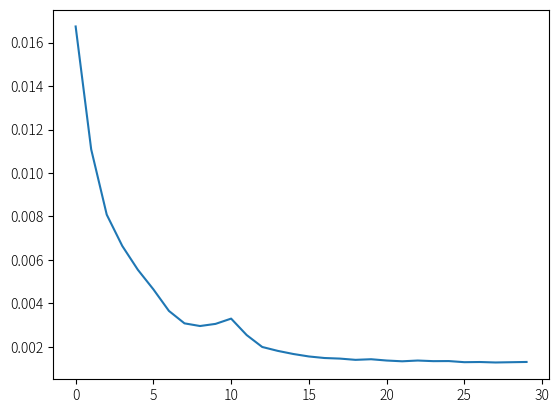

In [129]:
plt.plot(training_loss)

## baseline

In [130]:
EPOCHS = 30

In [131]:
trainer = RegressionTrainer(EPOCHS, DEVICE)
trainer.recorder.increment_data_size(len(train_dataset))

In [132]:
criterion = trainer.get_criterion(type='l1')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-1)#, weight_decay=1e-3)

In [133]:
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2, threshold=.05 ,threshold_mode ='rel')

In [134]:
training_loss = trainer.run(train_dataloader, baseline, optimizer, criterion, scheduler)

Enable AMP: False
Training...


100%|██████████| 6/6 [00:00<00:00, 64.16it/s]


------------------------------------
Epoch 1
------------------------------------
0.013175620010920932 (0%)


100%|██████████| 6/6 [00:00<00:00, 65.22it/s]


------------------------------------
Epoch 2
------------------------------------
0.013225684506552562 (0%)


100%|██████████| 6/6 [00:00<00:00, 62.48it/s]


------------------------------------
Epoch 3
------------------------------------
0.013222936732428414 (0%)


100%|██████████| 6/6 [00:00<00:00, 68.18it/s]


------------------------------------
Epoch 4
------------------------------------
0.01320174983569554 (0%)


100%|██████████| 6/6 [00:00<00:00, 71.40it/s]


------------------------------------
Epoch 5
------------------------------------
0.01322847298213414 (0%)


100%|██████████| 6/6 [00:00<00:00, 71.43it/s]


------------------------------------
Epoch 6
------------------------------------
0.013209239925657 (0%)


100%|██████████| 6/6 [00:00<00:00, 65.22it/s]


------------------------------------
Epoch 7
------------------------------------
0.013203495400292533 (0%)


100%|██████████| 6/6 [00:00<00:00, 67.42it/s]


------------------------------------
Epoch 8
------------------------------------
0.01317463380949838 (0%)


100%|██████████| 6/6 [00:00<00:00, 64.49it/s]


------------------------------------
Epoch 9
------------------------------------
0.013183404547827588 (0%)


100%|██████████| 6/6 [00:00<00:00, 66.63it/s]


------------------------------------
Epoch 10
------------------------------------
0.013165696689060757 (0%)


100%|██████████| 6/6 [00:00<00:00, 76.89it/s]


------------------------------------
Epoch 11
------------------------------------
0.013177319424492972 (0%)


100%|██████████| 6/6 [00:00<00:00, 73.13it/s]


------------------------------------
Epoch 12
------------------------------------
0.013180303573608398 (0%)


100%|██████████| 6/6 [00:00<00:00, 68.93it/s]


------------------------------------
Epoch 13
------------------------------------
0.013237037999289377 (0%)


100%|██████████| 6/6 [00:00<00:00, 75.95it/s]


------------------------------------
Epoch 14
------------------------------------
0.013185871498925346 (0%)


100%|██████████| 6/6 [00:00<00:00, 71.42it/s]


------------------------------------
Epoch 15
------------------------------------
0.013206156492233279 (0%)


100%|██████████| 6/6 [00:00<00:00, 72.26it/s]


------------------------------------
Epoch 16
------------------------------------
0.013197815418243409 (0%)


100%|██████████| 6/6 [00:00<00:00, 74.97it/s]


------------------------------------
Epoch 17
------------------------------------
0.013238446371895926 (0%)


100%|██████████| 6/6 [00:00<00:00, 73.17it/s]


------------------------------------
Epoch 18
------------------------------------
0.013238303491047449 (0%)


100%|██████████| 6/6 [00:00<00:00, 69.77it/s]


------------------------------------
Epoch 19
------------------------------------
0.013228493758610314 (0%)


100%|██████████| 6/6 [00:00<00:00, 63.08it/s]


------------------------------------
Epoch 20
------------------------------------
0.01319496853010995 (0%)


100%|██████████| 6/6 [00:00<00:00, 70.59it/s]


------------------------------------
Epoch 21
------------------------------------
0.013180000441414968 (0%)


100%|██████████| 6/6 [00:00<00:00, 58.26it/s]


------------------------------------
Epoch 22
------------------------------------
0.01318468655858721 (0%)


100%|██████████| 6/6 [00:00<00:00, 71.43it/s]


------------------------------------
Epoch 23
------------------------------------
0.013206643717629571 (0%)


100%|██████████| 6/6 [00:00<00:00, 77.93it/s]


------------------------------------
Epoch 24
------------------------------------
0.01316664627620152 (0%)


100%|██████████| 6/6 [00:00<00:00, 74.08it/s]


------------------------------------
Epoch 25
------------------------------------
0.013270011799676077 (1%)


100%|██████████| 6/6 [00:00<00:00, 47.24it/s]


------------------------------------
Epoch 26
------------------------------------
0.013220621858324323 (0%)


100%|██████████| 6/6 [00:00<00:00, 38.46it/s]


------------------------------------
Epoch 27
------------------------------------
0.01327743342944554 (0%)


100%|██████████| 6/6 [00:00<00:00, 42.55it/s]


------------------------------------
Epoch 28
------------------------------------
0.013239589418683733 (0%)


100%|██████████| 6/6 [00:00<00:00, 65.94it/s]


------------------------------------
Epoch 29
------------------------------------
0.013230347803660801 (0%)


100%|██████████| 6/6 [00:00<00:00, 62.50it/s]

------------------------------------
Epoch 30
------------------------------------
0.013221861805234637 (0%)


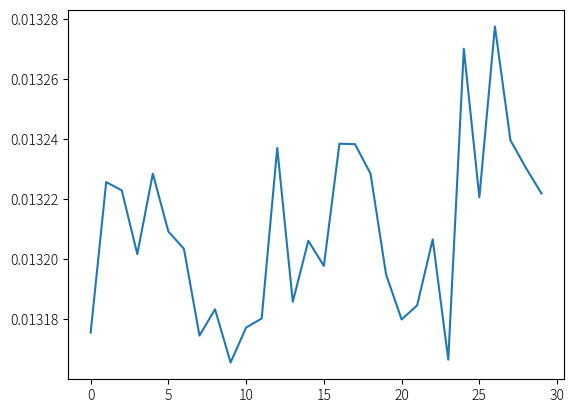

In [135]:
plt.plot(training_loss)

# eval

In [136]:
from torchmetrics.regression import MeanAbsolutePercentageError, MeanAbsoluteError, MeanSquaredError

In [137]:
Z = 1e4 / (len(val_dataset) * OUTPUT_SIZE)

### model

In [138]:
evaluator = RegressionEvaluator(DEVICE)

In [139]:
loss = evaluator.run(val_dataloader, model, metric=MeanAbsoluteError())

100%|██████████| 3/3 [00:00<00:00, 96.77it/s]

MeanAbsoluteError()


In [140]:
loss.compute() * Z

tensor(0.0439)

### baseline

In [141]:
evaluator = RegressionEvaluator(DEVICE)

In [142]:
loss = evaluator.run(val_dataloader, baseline, metric=MeanAbsoluteError())

100%|██████████| 3/3 [00:00<00:00, 93.75it/s]

MeanAbsoluteError()


In [143]:
loss.compute() * Z

tensor(0.3101)

## visualization

In [144]:
predictions = []
baseline_predictions = []
model.eval()
with torch.no_grad():
    for i in range(LONG_WINDOW_SIZE):
        val_x = train_dataset.data[-(LONG_WINDOW_SIZE - i):]
        if i > 0:
            val_x = np.concatenate([val_x, val_dataset.data[:i]])
        val_x = transform(val_x)
        val_x = torch.from_numpy(val_x).unsqueeze_(0).to(DEVICE)
        yhat = model(val_x).cpu()
        yhat_baseline = baseline(val_x.squeeze_(1)).cpu()
        predictions.append(yhat)
        baseline_predictions.append(yhat_baseline)
    
    for val_x, _ in val_dataset:
        val_x = torch.from_numpy(val_x).unsqueeze_(0).to(DEVICE)
        yhat = model(val_x).cpu()
        yhat_baseline = baseline(val_x.squeeze_(1)).cpu()
        predictions.append(yhat)
        baseline_predictions.append(yhat_baseline)
        
predictions = torch.cat(predictions)
baseline_predictions = torch.cat(baseline_predictions)
predictions.shape, baseline_predictions.shape

(torch.Size([366, 119]), torch.Size([366, 119]))

In [145]:
# predictions = torch.cat([torch.zeros(LONG_WINDOW_SIZE, OUTPUT_SIZE), predictions.cpu()])

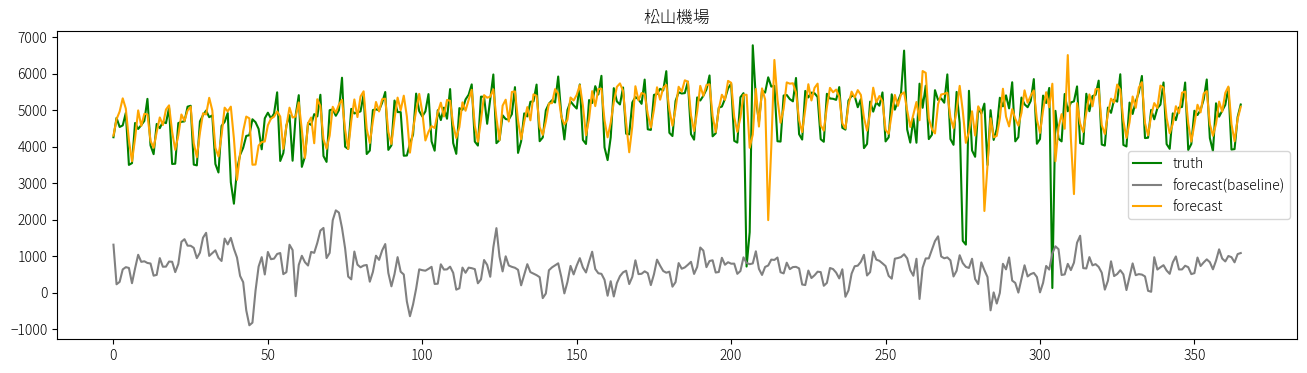

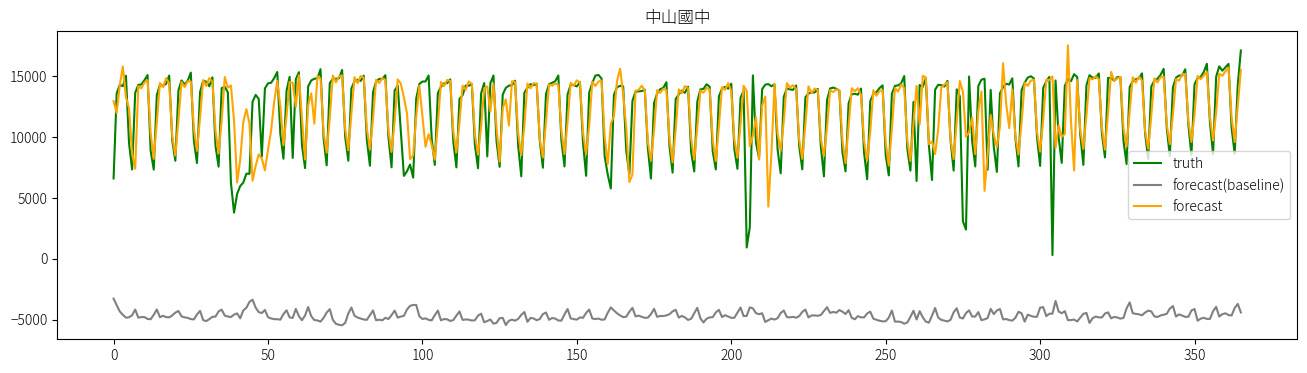

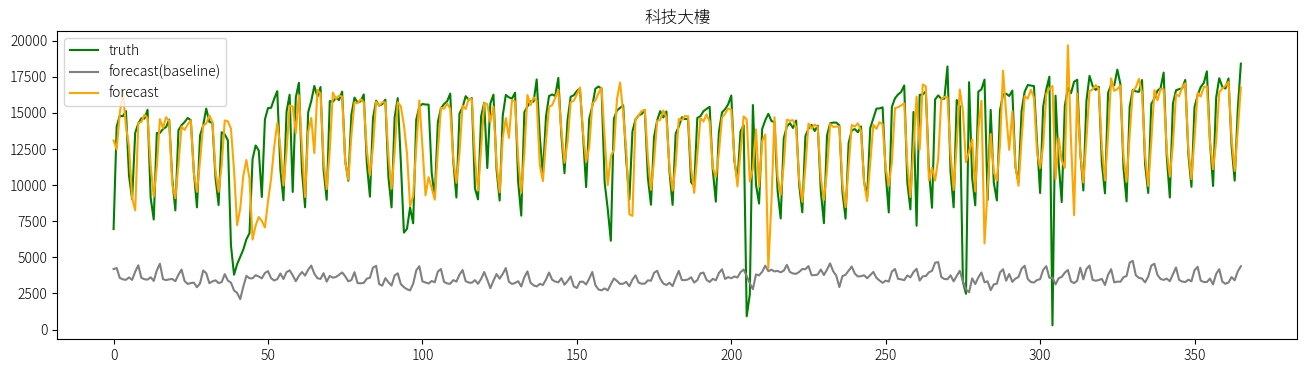

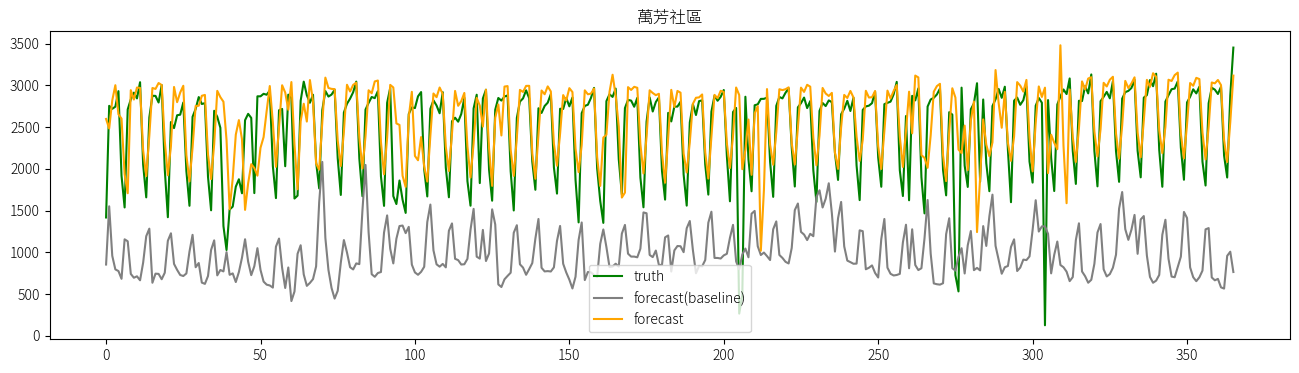

In [146]:
for station_idx in [0, 1, 5, 10]:
    plt.figure(figsize=(16, 4))
    plt.plot(val_dataset.data[:, station_idx], color='green', label='truth')
    plt.plot(baseline_predictions[:, station_idx].numpy()*10000, color='gray', label='forecast(baseline)')
    plt.plot(predictions[:, station_idx].numpy()*10000, color='orange', label='forecast')
    plt.legend()
    plt.title(val_dataset.stations[station_idx])

# save

In [147]:
model_path = artifact_path.joinpath("lstnet.pth")

In [148]:
torch.save(model.state_dict(), model_path)

In [149]:
get_file_size(model_path)

'0.81MiB'

In [150]:
model.load_state_dict(torch.load(model_path))

<All keys matched successfully>